In [21]:
import krotov
import qutip
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def hamiltonian(omega=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=1.5, func="blackman"
        )

    return [H0, [H1, guess_control]]


In [23]:
H = hamiltonian()

In [24]:
tlist = np.linspace(0, 5, 500)

In [25]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

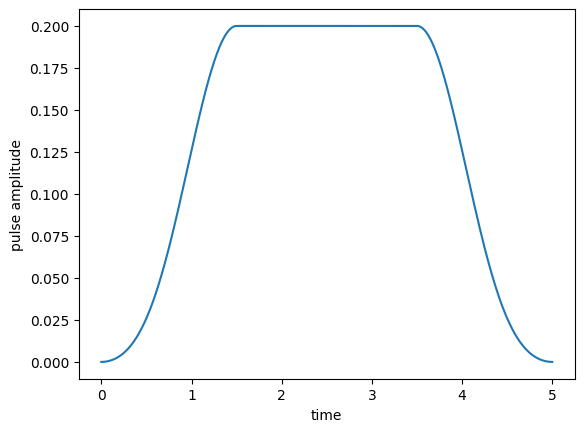

In [26]:
plot_pulse(H[1][1], tlist)

In [27]:
objectives = [
    krotov.Objective(
        initial_state=qutip.ket("0"), target=qutip.ket("1"), H=H
    )
]

objectives





[Objective[|Ψ₂(2)⟩ to |Ψ₃(2)⟩ via [H₂[2,2], [H₃[2,2], u₂(t)]]]]

In [28]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
    )

In [29]:
pulse_options = {
    H[1][1]: dict(lambda_a=5, update_shape=S)
}

In [30]:
proj0 = qutip.ket2dm(qutip.ket("0"))
proj1 = qutip.ket2dm(qutip.ket("1"))

In [31]:
proj0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [32]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

In [33]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

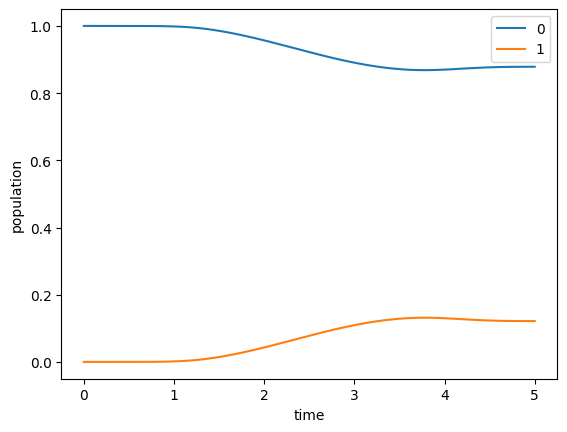

In [34]:
plot_population(guess_dynamics)

In [35]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     8.78e-01    0.00e+00   8.78e-01        n/a        n/a     0
1     8.06e-01    6.23e-03   8.12e-01  -7.26e-02  -6.63e-02     1
2     7.04e-01    8.82e-03   7.13e-01  -1.02e-01  -9.27e-02     1
3     5.77e-01    1.12e-02   5.88e-01  -1.27e-01  -1.16e-01     1
4     4.37e-01    1.26e-02   4.50e-01  -1.40e-01  -1.27e-01     1
5     3.05e-01    1.21e-02   3.17e-01  -1.32e-01  -1.20e-01     1
6     1.98e-01    9.94e-03   2.08e-01  -1.07e-01  -9.70e-02     1
7     1.22e-01    7.19e-03   1.29e-01  -7.64e-02  -6.93e-02     1
8     7.21e-02    4.72e-03   7.68e-02  -4.97e-02  -4.50e-02     1
9     4.17e-02    2.90e-03   4.46e-02  -3.04e-02  -2.75e-02     1
10    2.39e-02    1.71e-03   2.56e-02  -1.79e-02  -1.61e-02     1
11    1.36e-02    9.88e-04   1.46e-02  -1.03e-02  -9.31e-03     1
12    7.69e-03    5.64e-04   8.26e-03  -5.87e-03  -5.31e-03     1
13    4.36e-03    3.20e-04   4.68e-03  -3.33e-03  -3.01e-03     1
14    2.47

In [16]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2024-02-26 09:14:39
- Number of objectives: 1
- Number of iterations: 16
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2024-02-26 09:15:03 (0:00:24)

In [17]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])

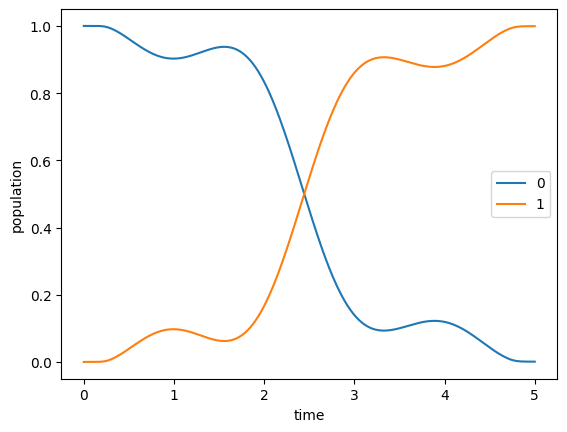

In [18]:
plot_population(opt_dynamics)

In [19]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_dyn] = plt.subplots(nrows=2, figsize=(8, 10))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[proj0, proj1]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color='#1f77b4',  # default blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#ff7f0e',  # default orange
            ls=ls,
            alpha=alpha,
        )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('population')
    ax_ctr.legend()
    ax_ctr.set_xlabel('time')
    ax_ctr.set_ylabel('control amplitude')
    plt.show(fig)

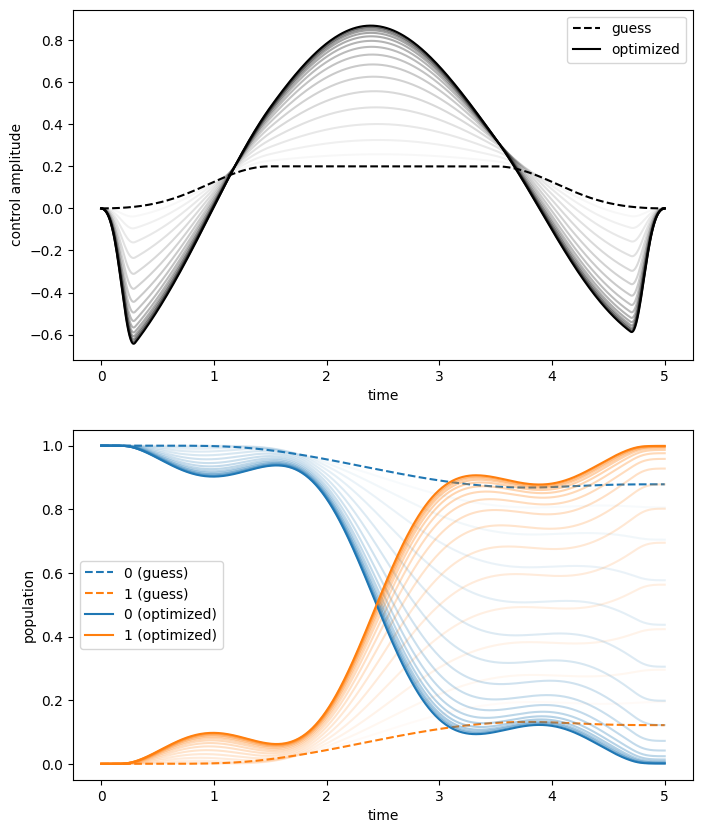

In [20]:
plot_iterations(opt_result)